## Imports

### Libraries

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
import wandb

### Tensorboard

In [4]:
%load_ext tensorboard

In [5]:
writer = SummaryWriter()

### Custom

In [6]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

from cv_geoguessr.utils.plot_images import plot_images

## Colab specific

Run only when using Colab.

In [7]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

## Logging in via WandB

In [8]:
wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", sync_tensorboard=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: ERROR No API key specified.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


KeyboardInterrupt: Interrupted by user

## Model constants

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
CELL_WIDTH = 0.04

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device = device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device = device)

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'
GCLOUD_CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
SJOERD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train_img" if train else "test_img"}/'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = GCLOUD_LONDON_PHOTO_DIR

SESSION = "douwes_v1_test"
CHECKPOINT_FOLDER = f'../checkpoints/{SESSION}/'


In [ ]:
wandb.config.update({"train_batch_size": TRAIN_BATCH_SIZE, "test_batch_size": TEST_BATCH_SIZE, "cell_width": CELL_WIDTH})

### ImageNet setup

In [10]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

--2022-06-05 10:02:01--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-06-05 10:02:01 (80.8 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [11]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

## Download ResNet50

In [12]:
resnet50 = models.resnet50(pretrained=True, progress=True)

resnet50.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load the data

### Create the data loaders

In [21]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

grid_partitioning = Partitioning(GCLOUD_CITY_BOUNDS_FILE, CELL_WIDTH)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some images

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


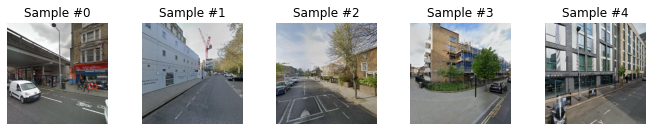

In [22]:
examples = enumerate(test_loader)
batch_idx, (eval_images, eval_coordinates) = next(examples)
eval_images = eval_images.to(device)
eval_coordinates = eval_coordinates.to(device)

plot_images(eval_images[:SAMPLES_TO_SHOW].cpu(), IMAGENET_MEAN.cpu(), IMAGENET_STD.cpu())

### Preview some output vectors

In [23]:
for i in range(SAMPLES_TO_SHOW):
    print(eval_coordinates[i, :])

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


## Evaluate the model
...with the current/original backbone

In [24]:
resnet50.eval()

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(eval_images[:SAMPLES_TO_SHOW]), dim=1)

In [25]:
for i in output:
    top5_prob, top5_catid = torch.topk(i, 5)

    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

    print("")

minibus 0.22720444202423096
passenger car 0.1523009091615677
tow truck 0.08299408107995987
limousine 0.07644613087177277
moving van 0.06439878046512604

liner 0.21117490530014038
dock 0.13329041004180908
passenger car 0.11292602866888046
container ship 0.10831142961978912
streetcar 0.04728379473090172

shopping cart 0.18873333930969238
limousine 0.07393687963485718
ashcan 0.04562284052371979
traffic light 0.0420088917016983
cab 0.034820299595594406

prison 0.07622098177671432
streetcar 0.06054055318236351
cab 0.04382024705410004
garbage truck 0.037265900522470474
shopping cart 0.03403378650546074

prison 0.14514964818954468
streetcar 0.13578270375728607
shopping cart 0.10116740316152573
pier 0.07739844918251038
parking meter 0.07267861813306808



##  Change network backbone to grid cells

In [26]:
lr = 0.001
momentum = 0.9
gamma = 0.1
lr_decay_step = 7
num_epochs = 25

wandb.config.update({"lr": lr, "momentum": momentum, "gamma": gamma, "lr_decay_step": lr_decay_step, "epochs": num_epochs})

Error: You must call wandb.init() before wandb.config.update

In [27]:
from torch.optim import lr_scheduler
from torch import optim

number_of_grid_elements = len(grid_partitioning.cells)

for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Linear(resnet50.fc.in_features, number_of_grid_elements).to(device)
resnet50.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(resnet50.fc.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=lr_decay_step, gamma=gamma)

In [ ]:
wandb.config.update({"number_of_grid_elements": number_of_grid_elements})

In [28]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Set up training pipeline

In [ ]:
import copy
from datetime import time

data_loaders = {
    "train": train_loader,
    "val": test_loader
}


data_set_sizes = {
    'train': len(train_data_set),
    'val': len(test_data_set),
}

print(data_set_sizes)

In [ ]:
import os

if not os.path.isdir(CHECKPOINT_FOLDER):
    os.makedirs(CHECKPOINT_FOLDER)

torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "untrained.ckpt")

In [ ]:
import copy
import time


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains a model, based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

    :param model: the model to train
    :param criterion: the criterion to use
    :param optimizer: the optimizer to use
    :param scheduler: torch.optim.lr_scheduler
    :param num_epochs:
    :return: a trained model
    """

    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_acc = 0
        test_acc = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward: track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                _, actual_label_index = torch.max(labels, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == actual_label_index)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / data_set_sizes[phase]
            epoch_acc = running_corrects.double() / data_set_sizes[phase]

            writer.add_scalar(f"Loss/{phase}", epoch_loss, epoch)
            wandb.log({f"Loss/{phase}": epoch_loss, "epoch": epoch})
            writer.add_scalar(f"Accuracy/{phase}", epoch_acc, epoch)
            wandb.log({f"Accuracy/{phase}": epoch_acc, "epoch": epoch})

            if phase == 'train':
                train_acc = epoch_acc
            else:
                test_acc = epoch_acc

            print(f'{phase} loss: {epoch_loss:.4f} | accuracy: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print(f"{train_acc}\t{test_acc}")

        torch.save(resnet50.state_dict(),
                   CHECKPOINT_FOLDER + f"epoch_{epoch}.ckpt")

    time_elapsed = time.time() - since

    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model)

    writer.flush()

    return model


## Set up Tensorboard

In [ ]:
%tensorboard --logdir runs/

In [ ]:
# Lets train the model
trained_model = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)


## Clean up TensorBoard data

In [ ]:
!rm -r runs